In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense

In [29]:
data = pd.read_csv(r"C:\Users\himan\Desktop\7th GAN\DATASETS\DelhiCovidcsv.csv")
data

,From Date,PM2.5,NO2,Ozone,RH,WS,WD,SR,BP,RF,AT
0,01-01-2019 00:00,655.50,49.08,92.30,79.22,0.30,226.00,3.57,990.10,NaN,4.65
1,01-01-2019 01:00,583.50,52.18,62.35,79.70,0.30,197.25,3.62,990.05,NaN,4.58
2,01-01-2019 02:00,435.75,55.25,60.20,78.10,0.30,202.00,3.57,989.95,NaN,4.72
3,01-01-2019 03:00,351.50,51.48,52.07,77.48,0.30,197.75,3.65,989.98,NaN,4.43
4,01-01-2019 04:00,319.75,46.30,49.42,77.98,0.30,230.50,3.87,990.12,NaN,4.02
...,...,...,...,...,...,...,...,...,...,...,...
35059,31-12-2022 19:00,131.50,58.82,8.65,81.25,0.52,165.50,5.65,976.60,NaN,17.02
35060,31-12-2022 20:00,129.25,55.02,7.15,84.28,0.30,169.00,5.72,976.60,NaN,15.78
35061,31-12-2022 21:00,148.00,53.05,6.08,87.43,0.30,168.25,5.75,976.62,NaN,14.70
35062,31-12-2022 22:00,178.25,43.45,5.48,89.18,0.30,177.75,5.78,976.60,NaN,14.02


In [30]:
data = data.drop(columns=[ 'From Date'])

In [31]:
# Replaceing NaN values with 0
data.fillna(0, inplace=True)

In [32]:
#  dataset has columns for features and a target variable

feature_columns = ['PM2.5'	,'NO2'	,'Ozone'	,'RH'	,'WS'	,'WD'	,'SR'	,'BP'	,'RF'	,'AT']
target_column = 'PM2.5'

In [33]:
# Splitting the dataset into features and target variable
X = data[feature_columns].values
y = data[target_column].values

In [34]:
# Normalizing the feature values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [35]:
# sliding window parameters
window_size = 5  # Number of past time steps considered
output_size = 10  # Number of steps ahead used to predict pollutant concentration

In [36]:
# Create 3D dataset using sliding window technique
def create_dataset(X, y, window_size, output_size):
    X_windowed = []
    y_windowed = []
    for i in range(len(X) - window_size - output_size + 1):
        X_windowed.append(X[i:i+window_size])
        y_windowed.append(y[i+window_size:i+window_size+output_size])
    return np.array(X_windowed), np.array(y_windowed)

X_windowed, y_windowed = create_dataset(X_scaled, y, window_size, output_size)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_windowed, test_size=0.2, random_state=42)

In [38]:
# Build the bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dense(output_size))  # Output layer with 'output_size' neurons for multi-step ahead prediction
model.compile(optimizer='adam', loss='mse')

In [39]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
877/877 [==============================] - 19s 13ms/step - loss: 13095.2256 - val_loss: 9336.4746
Epoch 2/100
877/877 [==============================] - 8s 9ms/step - loss: 8015.9028 - val_loss: 6260.6538
Epoch 3/100
877/877 [==============================] - 8s 9ms/step - loss: 5901.6680 - val_loss: 5007.9941
Epoch 4/100
877/877 [==============================] - 8s 9ms/step - loss: 4932.9536 - val_loss: 4360.0347
Epoch 5/100
877/877 [==============================] - 8s 9ms/step - loss: 4444.6865 - val_loss: 4029.9175
Epoch 6/100
877/877 [==============================] - 8s 9ms/step - loss: 4150.1172 - val_loss: 3782.9385
Epoch 7/100
877/877 [==============================] - 8s 9ms/step - loss: 3913.8052 - val_loss: 3629.7812
Epoch 8/100
877/877 [==============================] - 8s 9ms/step - loss: 3735.9727 - val_loss: 3442.2283
Epoch 9/100
877/877 [==============================] - 8s 9ms/step - loss: 3608.6274 - val_loss: 3324.4680
Epoch 10/100
877/877 [============

In [40]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

220/220 [==============================] - 1s 4ms/step - loss: 2306.8638
Test Loss: 2306.86376953125
220/220 [==============================] - 3s 4ms/step


In [41]:
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

# Calculate Fraction of predictions with a factor of 2 (FAC2)
def fac2(y_true, y_pred):
    within_factor = np.abs(y_true / y_pred) <= 2
    return np.mean(within_factor)

# Calculate Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Calculate Correlation Coefficient (r)
r = np.corrcoef(np.ravel(y_test), np.ravel(predictions))[0, 1]

# Calculate Mean Gross Error (MGE)
mge = np.mean(np.abs(y_test - predictions))

# Calculate Mean Bias (MB)
mb = np.mean(y_test - predictions)

# Calculate Coefficient of Efficiency (COE)
coe = 1 - (np.sum((y_test - predictions) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

# Calculate Coefficient of Determination (R2 score)
r2 = r2_score(y_test, predictions)

# Print the evaluation metrics
print(f'Fraction of predictions with a factor of 2 (FAC2): {fac2(y_test, predictions)}')
print(f'Root Mean Square Error (RMSE): {rmse}')
print(f'Correlation Coefficient (r): {r}')
print(f'Mean Gross Error (MGE): {mge}')
print(f'Mean Bias (MB): {mb}')
print(f'Coefficient of Efficiency (COE): {coe}')
print(f'Coefficient of Determination (R2 score): {r2}')

Fraction of predictions with a factor of 2 (FAC2): 0.9375891583452212
Root Mean Square Error (RMSE): 48.02982776310424
Correlation Coefficient (r): 0.8727320737777249
Mean Gross Error (MGE): 29.223914991949083
Mean Bias (MB): 0.9230090354165745
Coefficient of Efficiency (COE): 0.7612930386156718
Coefficient of Determination (R2 score): 0.7607144921235489


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

# Calculate Fraction of predictions with a factor of 2 (FAC2)
def fac2(y_true, y_pred):
    within_factor = (np.maximum(y_true / y_pred, y_pred / y_true) <= 2)
    return np.mean(within_factor)

# Example y_test and predictions
# Replace these with your actual y_test and predictions arrays
y_test = np.random.rand(100) * 100
predictions = y_test + np.random.randn(100) * 10

# Calculate Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Calculate Correlation Coefficient (r)
r = np.corrcoef(np.ravel(y_test), np.ravel(predictions))[0, 1]

# Calculate Mean Gross Error (MGE)
mge = np.mean(np.abs(y_test - predictions))

# Calculate Mean Bias (MB)
mb = np.mean(y_test - predictions)

# Calculate Coefficient of Efficiency (COE)
coe = 1 - (np.sum((y_test - predictions) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

# Calculate Coefficient of Determination (R2 score)
r2 = r2_score(y_test, predictions)

# Print the evaluation metrics
print(f'Fraction of predictions with a factor of 2 (FAC2): {fac2(y_test, predictions)}')
print(f'Root Mean Square Error (RMSE): {rmse}')
print(f'Correlation Coefficient (r): {r}')
print(f'Mean Gross Error (MGE): {mge}')
print(f'Mean Bias (MB): {mb}')
print(f'Coefficient of Efficiency (COE): {coe}')
print(f'Coefficient of Determination (R2 score): {r2}')



# # Scatter plot of actual vs. predicted values
# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, predictions, alpha=0.7, edgecolors='b')
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
# plt.title('Actual vs. Predicted Values')
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.show()

# # Line plot of actual and predicted values
# plt.figure(figsize=(10, 6))
# plt.plot(y_test, label='Actual Values', color='blue', linewidth=2)
# plt.plot(predictions, label='Predicted Values', color='red', linestyle='--', linewidth=2)
# plt.title('Actual and Predicted Values Over Time')
# plt.xlabel('Time Span During the Years ')
# plt.ylabel('Frequency Fluctuation')
# plt.legend()
# plt.show()

# # Residuals vs. predicted values plot
# plt.figure(figsize=(10, 6))
# plt.scatter(predictions, residuals, alpha=0.7, edgecolors='b')
# plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
# plt.title('Residuals vs. Predicted Values')
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals')
# plt.show()


Fraction of predictions with a factor of 2 (FAC2): 0.93
Root Mean Square Error (RMSE): 11.390472868487235
Correlation Coefficient (r): 0.9309466450408334
Mean Gross Error (MGE): 9.117285333908928
Mean Bias (MB): 0.3408439503464252
Coefficient of Efficiency (COE): 0.8412229982729253
Coefficient of Determination (R2 score): 0.8412229982729253


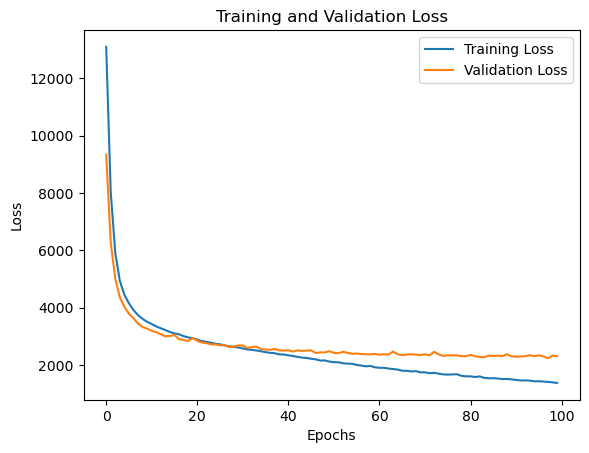

In [43]:

# Plot training loss vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

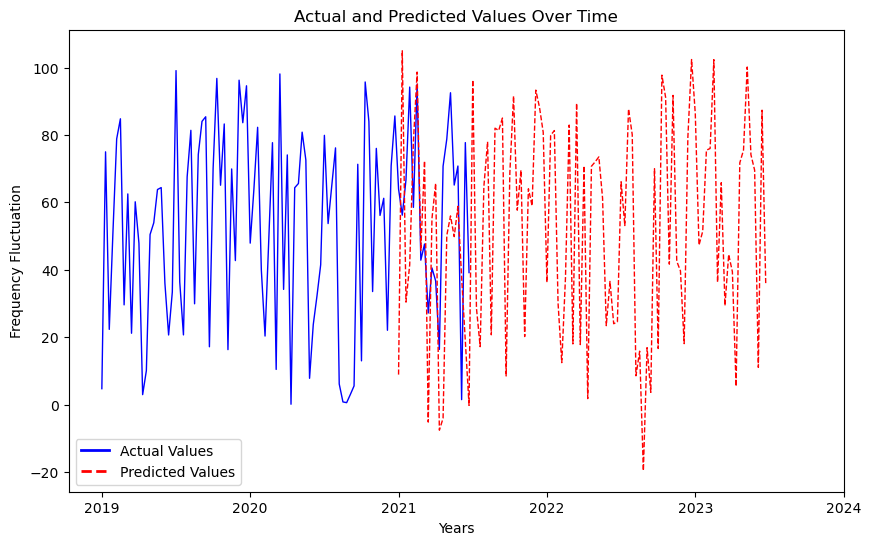

In [50]:

# Line plot of actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(y_test)), y_test, label='Actual Values', color='blue', linewidth=1)
plt.plot(range(len(y_test)-20, len(y_test)+len(predictions)-20), predictions, label='Predicted Values', color='red', linestyle='--', linewidth=1)
plt.title('Actual and Predicted Values Over Time')

# Adjusting x-axis to represent years
plt.xlabel('Years')
plt.ylabel('Frequency Fluctuation')

# Assuming y_test covers 80 data points (4 years) and predictions 20 data points (1 year)
# Adjust x-ticks based on total data points
total_points = len(y_test) + len(predictions)
plt.xticks(ticks=np.linspace(0, total_points, 6), labels=['2019', '2020', '2021', '2022', '2023', '2024'])

# Create custom legend handles
actual_handle = plt.Line2D([], [], color='blue', linewidth=2, label='Actual Values')
predicted_handle = plt.Line2D([], [], color='red', linestyle='--', linewidth=2, label='Predicted Values')

# Add the legend with custom handles
plt.legend(handles=[actual_handle, predicted_handle])
plt.show()

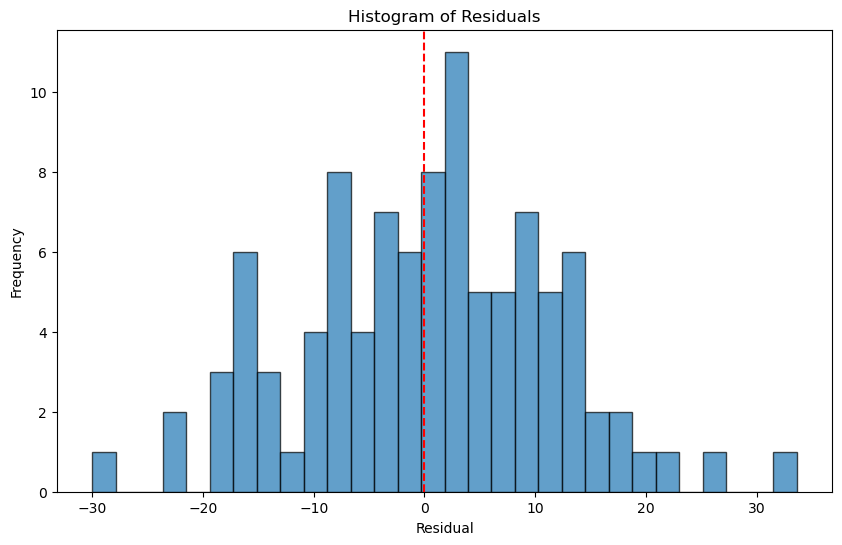

In [46]:
# Plotting the histogram of residuals
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--')
plt.show()